# GAN


!(https://developers.google.com/machine-learning/gan/gan_structure)

In [5]:
# basic
import os
import datetime
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np

# torch
import torch.autograd as autograd
import torch.optim as optim
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
from torch.nn.utils import spectral_norm

# other
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import itertools
import glob


# DATASET + MODELY

* **`Signal1DDataset`**

  * Loads signal data from CSV files, grouped by experiment IDs.
  * Each sample contains:

    * A **1D signal** (from column `"intensity"` or last column).
    * A **condition vector** (from parameter CSV, excluding `experiment` column).
  * Supports:

    * Global **signal normalization** to `[-1, 1]`.
    * **Condition normalization** to zero mean, unit variance.

* **`Generator1D`**

  * Takes a random noise vector and a condition vector.
  * Produces a **synthetic 1D signal** of length `signal_len` in range `[-1, 1]`.

* **`Discriminator1D`**

  * Takes a signal (real or generated) and a condition vector.
  * Uses 1D convolutions to extract features.
  * Outputs a single scalar (real vs fake score).



In [8]:
class Signal1DDataset(Dataset):
    def __init__(self, root_dir, params_csv, allowed_experiments=None,
                 normalize_signals=True, normalize_conditions=True):
        """
        Custom PyTorch dataset for loading 1D signal CSV files along with
        associated experimental conditions.

        Args:
            root_dir (str): Root directory containing subfolders for experiments.
            params_csv (str): Path to CSV with experiment parameters.
                              Must contain a column 'experiment' linking to folders.
            allowed_experiments (list[int], optional): Subset of experiments to use.
            normalize_signals (bool): Whether to apply global min-max normalization
                                      of signals into [-1, 1].
            normalize_conditions (bool): Whether to standardize conditions
                                         (zero mean, unit variance).
        """
        self.root_dir = root_dir
        self.params_df = pd.read_csv(params_csv)

        if allowed_experiments is not None:
            self.params_df = self.params_df[self.params_df["experiment"].isin(allowed_experiments)]

        self.samples = []
        for _, row in self.params_df.iterrows():
            folder_id = str(int(row["experiment"]))
            folder_path = os.path.join(root_dir, folder_id)
            if not os.path.isdir(folder_path):
                continue
            for fname in os.listdir(folder_path):
                if fname.lower().endswith(".csv"):
                    fpath = os.path.join(folder_path, fname)
                    conditions = row.drop("experiment").values
                    self.samples.append((fpath, conditions))

        print(f"Loaded {len(self.samples)} files (experiments={allowed_experiments})")

        # === global signal normalization ===
        self.normalize_signals = normalize_signals
        if normalize_signals and len(self.samples) > 0:
            all_signals = []
            for fpath, _ in self.samples:
                df = pd.read_csv(fpath)
                if "intensity" in df.columns:
                    sig = df["intensity"].values.astype(np.float32)
                else:
                    sig = df.iloc[:, -1].values.astype(np.float32)
                all_signals.append(sig)

            all_signals = np.concatenate(all_signals)
            self.global_min = all_signals.min()
            self.global_max = all_signals.max()
            print(f"Global normalization: min={self.global_min:.4f}, max={self.global_max:.4f}")

        # === condition normalization ===
        self.normalize_conditions = normalize_conditions
        if normalize_conditions and len(self.samples) > 0:
            all_conditions = np.stack([s[1] for s in self.samples])
            self.cond_mean = all_conditions.mean(axis=0)
            self.cond_std = all_conditions.std(axis=0)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        signal_path, cond = self.samples[idx]
        df = pd.read_csv(signal_path)

        if "intensity" in df.columns:
            signal = df["intensity"].values.astype(np.float32)
        else:
            signal = df.iloc[:, -1].values.astype(np.float32)

        # global normalization
        if self.normalize_signals:
            signal = (signal - self.global_min) / (self.global_max - self.global_min + 1e-8)
            signal = signal * 2.0 - 1.0  # range [-1, 1]

        # condition normalization
        cond = cond.astype(np.float32)
        if self.normalize_conditions:
            cond = (cond - self.cond_mean) / (self.cond_std + 1e-8)

        return torch.from_numpy(signal), torch.from_numpy(cond)


class ResBlock1D(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=7, stride=1, padding=3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm1d(out_ch)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm1d(out_ch)

        # skip connection pro změnu dimenze
        self.skip = None
        if in_ch != out_ch:
            self.skip = nn.Conv1d(in_ch, out_ch, 1)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.skip is not None:
            identity = self.skip(identity)
        return F.relu(out + identity)

class Generator1D(nn.Module):
    def __init__(self, noise_dim=64, cond_dim=5, signal_len=450):
        super().__init__()
        self.noise_dim = noise_dim
        self.cond_dim = cond_dim
        self.signal_len = signal_len

        input_dim = noise_dim + cond_dim

        # latentní reprezentace s fixní délkou (např. 32)
        self.latent_len = 32
        self.fc = nn.Linear(input_dim, 128 * self.latent_len)

        self.deconv_blocks = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(True),

            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(True),

            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
        )

        self.final_conv = nn.Conv1d(16, 1, kernel_size=7, padding=3)

    def forward(self, noise, cond):
        x = torch.cat([noise, cond], dim=1)
        x = self.fc(x)
        x = x.view(x.size(0), 128, self.latent_len)
        x = self.deconv_blocks(x)
        x = self.final_conv(x)  # (B,1,L')

        # pokud L' != požadované délce, resamplujeme
        x = F.interpolate(x, size=self.signal_len, mode="linear", align_corners=False)

        return torch.tanh(x.squeeze(1))

    

# === Discriminator ===
class Discriminator1D(nn.Module):
    def __init__(self, cond_dim=5, signal_len=450):
        super().__init__()
        self.signal_len = signal_len
        self.cond_dim = cond_dim

        # feature extractor s SpectralNorm
        self.conv_blocks = nn.Sequential(
            spectral_norm(nn.Conv1d(1, 32, kernel_size=7, stride=2, padding=3)),
            nn.LeakyReLU(0.2),

            spectral_norm(nn.Conv1d(32, 64, kernel_size=7, stride=2, padding=3)),
            nn.LeakyReLU(0.2),

            spectral_norm(nn.Conv1d(64, 128, kernel_size=7, stride=2, padding=3)),
            nn.LeakyReLU(0.2),

            spectral_norm(nn.Conv1d(128, 256, kernel_size=7, stride=2, padding=3)),
            nn.LeakyReLU(0.2),
        )

        # zjistíme dimenzi
        with torch.no_grad():
            dummy = torch.zeros(1, 1, signal_len)
            out = self.conv_blocks(dummy)
            flat_dim = out.view(1, -1).size(1)

        # fully connected + condition
        self.fc = nn.Sequential(
            spectral_norm(nn.Linear(flat_dim + cond_dim, 128)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Linear(128, 1))
        )

    def forward(self, signal, cond):
        x = signal.unsqueeze(1)        # (B, 1, L)
        x = self.conv_blocks(x)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, cond], dim=1)
        return self.fc(x)              # (B, 1)


# TRAIN

* **`train_wgan_gp_l1`**

  * Training loop for WGAN-GP with extra **L1 loss** (encourages signals to match real ones).
  * Updates the **discriminator multiple times per generator update** (`n_critic`).
  * Supports **λL1 decay** and optional **validation with saving outputs**.

* **`gradient_penalty`**

  * Implements the **gradient penalty** term from WGAN-GP.
  * Enforces Lipschitz constraint by penalizing deviation of gradient norm from 1.

* **`validate_gan`**

  * Samples random real signals + conditions.
  * Generates fake signals under same conditions.
  * Plots **real vs generated** side by side for visual sanity check.


In [3]:
def train_wgan_gp_l1(G, D, train_loader, noise_dim, num_epochs=50,
                     lr_G=1e-4, lr_D=5e-5, device="cpu",
                     n_critic=2, lambda_gp=1.0, lambda_l1=10.0,
                     l1_decay_every=None,
                     val_dataset=None, run_dir=None, validate_every=10):
    """
    Hybrid training loop for conditional WGAN-GP with additional L1 reconstruction loss.

    Args:
        G (nn.Module): Generator model.
        D (nn.Module): Discriminator (critic) model.
        train_loader (DataLoader): Training data loader.
        noise_dim (int): Dimension of input noise vector.
        num_epochs (int): Number of training epochs.
        lr_G (float): Learning rate for generator.
        lr_D (float): Learning rate for discriminator.
        device (str): "cpu" or "cuda".
        n_critic (int): Number of discriminator updates per generator update.
        lambda_gp (float): Gradient penalty coefficient.
        lambda_l1 (float): Weight for L1 reconstruction loss.
        l1_decay_every (int or None): Halve lambda_l1 every given epochs.
        val_dataset (Dataset or None): Validation dataset.
        run_dir (str or None): Directory for saving validation outputs.
        validate_every (int): Run validation every N epochs.

    Returns:
        dict: Training history with loss_D, loss_G, lambda_l1.
    """
    optimizer_G = optim.Adam(G.parameters(), lr=lr_G, betas=(0.0, 0.9))
    optimizer_D = optim.Adam(D.parameters(), lr=lr_D, betas=(0.0, 0.9))

    history = {"loss_D": [], "loss_G": [], "lambda_l1": []}

    for epoch in range(num_epochs):
        loss_D_epoch, loss_G_epoch = 0.0, 0.0

        # decay λL1
        if l1_decay_every is not None and (epoch > 0) and (epoch % l1_decay_every == 0):
            lambda_l1 = lambda_l1 / 2.0
            print(f"[Epoch {epoch}] Decaying lambda_l1 → {lambda_l1}")

        for signals, conds in train_loader:
            signals = signals.to(device).float()
            conds = conds.to(device).float()
            b_size = signals.size(0)

            # --- Critic update ---
            for _ in range(n_critic):
                noise = torch.randn(b_size, noise_dim, device=device)
                fake_signals = G(noise, conds)

                D.zero_grad()
                real_validity = D(signals, conds)
                fake_validity = D(fake_signals.detach(), conds)

                gp = gradient_penalty(D, signals, fake_signals, conds, device, lambda_gp)
                loss_D = fake_validity.mean() - real_validity.mean() + gp

                loss_D.backward()
                optimizer_D.step()

            # --- Generator update ---
            noise = torch.randn(b_size, noise_dim, device=device)
            fake_signals = G(noise, conds)

            G.zero_grad()
            fake_validity = D(fake_signals, conds)

            adv_loss = -fake_validity.mean()
            l1_loss = F.l1_loss(fake_signals, signals)
            loss_G = adv_loss + lambda_l1 * l1_loss

            loss_G.backward()
            optimizer_G.step()

            loss_D_epoch += loss_D.item()
            loss_G_epoch += loss_G.item()

        # epoch averages
        loss_D_epoch /= len(train_loader)
        loss_G_epoch /= len(train_loader)
        history["loss_D"].append(loss_D_epoch)
        history["loss_G"].append(loss_G_epoch)
        history["lambda_l1"].append(lambda_l1)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Loss_D: {loss_D_epoch:.4f} Loss_G: {loss_G_epoch:.4f} (λL1={lambda_l1:.2f})")

        # --- Validation ---
        if val_dataset is not None and run_dir is not None:
            if (epoch+1) % validate_every == 0 or (epoch+1) == num_epochs:
                val_df = validate_and_save_all(G, val_dataset, noise_dim=noise_dim,
                                               device=device, save_dir=run_dir, epoch=epoch+1)
                print(f"[Epoch {epoch+1}] Val mean MSE={val_df['MSE'].mean():.4f}, "
                      f"Corr={val_df['Corr'].mean():.4f}")

    return history


def gradient_penalty(D, real_data, fake_data, cond, device="cpu", lambda_gp=10):
    """
    Computes gradient penalty for WGAN-GP.

    Args:
        D (nn.Module): Discriminator (critic).
        real_data (Tensor): Batch of real signals.
        fake_data (Tensor): Batch of generated signals.
        cond (Tensor): Condition vectors.
        device (str): Device.
        lambda_gp (float): Penalty weight.

    Returns:
        Tensor: Gradient penalty term.
    """
    b_size = real_data.size(0)
    alpha = torch.rand(b_size, 1, device=device).expand_as(real_data)

    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    d_interpolates = D(interpolates, cond)

    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(b_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    gp = ((gradient_norm - 1) ** 2).mean() * lambda_gp
    return gp


def validate_gan(G, val_dataset, noise_dim=64, num_samples=5, device="cpu"):
    """
    Visual validation of GAN outputs.

    Args:
        G (nn.Module): Generator model.
        val_dataset (Dataset): Validation dataset.
        noise_dim (int): Noise dimension.
        num_samples (int): Number of samples to visualize.
        device (str): Device.

    Side effects:
        Displays matplotlib plots comparing real vs. generated signals.
    """
    G.eval()
    indices = np.random.choice(len(val_dataset), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 8), sharex=True)
    for i, idx in enumerate(indices):
        real_signal, cond = val_dataset[idx]
        cond = cond.unsqueeze(0).to(device).float()
        noise = torch.randn(1, noise_dim, device=device)
        with torch.no_grad():
            fake_signal = G(noise, cond).cpu().numpy().flatten()

        axes[i].plot(real_signal.numpy(), label="Real", color="black")
        axes[i].plot(fake_signal, label="Generated", color="red", alpha=0.7)
        axes[i].legend()
    plt.suptitle("Validation: Real vs Generated Signals")
    plt.show()


# VALIDATE

* **`validate_gan_with_metrics`**

  * Picks a few random samples from the dataset.
  * Generates fake signals under the same conditions.
  * Computes **MSE** and **Pearson correlation** between real and fake signals.
  * Visualizes and optionally saves the plots.

* **`validate_and_save_all`**

  * Runs generator across the **entire validation dataset**.
  * Computes and saves per-sample metrics (**MSE, Corr**) into a CSV.
  * Saves arrays of real and generated signals (`.npy`).
  * Produces histograms of metric distributions for quick diagnostics.



In [4]:
def validate_gan_with_metrics(G, dataset, noise_dim=64, num_samples=3, device="cpu", save_dir=None):
    """
    Validate generator on a random subset of the dataset and compute metrics.

    Args:
        G (nn.Module): Generator model.
        dataset (Dataset): Dataset with real signals and conditions.
        noise_dim (int): Dimension of the noise vector.
        num_samples (int): Number of random samples to visualize.
        device (str): Device ("cpu" or "cuda").
        save_dir (str or None): If provided, save the plots to this directory.

    Returns:
        list[dict]: List of dictionaries with indices, MSE and correlation.
    """
    G.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    results = []

    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 6), sharex=True)

    for i, idx in enumerate(indices):
        real_signal, cond = dataset[idx]
        real_signal = real_signal.numpy()

        cond = cond.unsqueeze(0).to(device).float()
        noise = torch.randn(1, noise_dim, device=device)

        with torch.no_grad():
            fake_signal = G(noise, cond).cpu().numpy().flatten()

        mse = mean_squared_error(real_signal, fake_signal)
        corr, _ = pearsonr(real_signal, fake_signal)
        results.append({"idx": idx, "MSE": mse, "Corr": corr})

        axes[i].plot(real_signal, label="Real", color="black")
        axes[i].plot(fake_signal, label="Generated", color="red", alpha=0.7)
        axes[i].legend()
        axes[i].set_title(f"Sample {idx} | MSE={mse:.4f}, Corr={corr:.3f}")

    plt.suptitle("Validation: Real vs Generated signals (with metrics)")
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, "validation_examples.png"), dpi=200)
        plt.close()
    else:
        plt.show()

    return results


def validate_and_save_all(G, dataset, noise_dim=64, device="cpu", save_dir="results", epoch=None):
    """
    Evaluate generator on the entire validation dataset and save results.

    For each sample:
      - Generates a fake signal given the real condition.
      - Computes MSE and Pearson correlation with the real signal.
      - Saves signals and metrics to disk.

    Args:
        G (nn.Module): Generator model.
        dataset (Dataset): Validation dataset.
        noise_dim (int): Dimension of noise vector.
        device (str): Device ("cpu" or "cuda").
        save_dir (str): Directory for saving outputs.
        epoch (int or None): If provided, appended to filenames.

    Returns:
        pd.DataFrame: DataFrame with per-sample metrics (MSE, Corr).
    """
    G.eval()
    all_results = []
    real_signals, fake_signals = [], []

    for idx in range(len(dataset)):
        real_signal, cond = dataset[idx]
        real_signal_np = real_signal.numpy()

        cond = cond.unsqueeze(0).to(device).float()
        noise = torch.randn(1, noise_dim, device=device)

        with torch.no_grad():
            fake_signal = G(noise, cond).cpu().numpy().flatten()

        mse = mean_squared_error(real_signal_np, fake_signal)
        corr, _ = pearsonr(real_signal_np, fake_signal)

        all_results.append({"idx": idx, "MSE": mse, "Corr": corr})
        real_signals.append(real_signal_np)
        fake_signals.append(fake_signal)

    df = pd.DataFrame(all_results)

    # --- dynamic filenames depending on epoch ---
    suffix = f"_epoch{epoch}" if epoch is not None else ""
    df.to_csv(os.path.join(save_dir, f"validation_metrics{suffix}.csv"), index=False)

    np.save(os.path.join(save_dir, f"real_signals{suffix}.npy"), np.array(real_signals))
    np.save(os.path.join(save_dir, f"fake_signals{suffix}.npy"), np.array(fake_signals))

    # histograms of metrics
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(df["MSE"], bins=30, color="skyblue", edgecolor="black")
    plt.title("MSE distribution")
    plt.xlabel("MSE"); plt.ylabel("Count")

    plt.subplot(1, 2, 2)
    plt.hist(df["Corr"], bins=30, color="salmon", edgecolor="black")
    plt.title("Correlation distribution")
    plt.xlabel("Pearson corr"); plt.ylabel("Count")

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"validation_metrics_hist{suffix}.png"), dpi=200)
    plt.close()

    return df


# MAIN

1. **Dataset split**

   * Splits experiments into train/val sets (80/20).
   * Saves or reloads the split from `dataset_split.csv`.

2. **Dataset + DataLoader**

   * Initializes `Signal1DDataset` for train and validation.
   * Builds PyTorch `DataLoader`.

3. **Model initialization**

   * Derives signal length and condition dimension from dataset.
   * Creates `Generator1D` and `Discriminator1D`.

4. **Grid search**

   * Iterates over combinations of `λL1` weights and number of epochs.
   * Each run has its own timestamped results directory.

5. **Training**

   * Calls `train_wgan_gp_l1` with given parameters.
   * Tracks losses and saves them in CSV/JSON.

6. **Saving**

   * Stores trained models (`.pth`).
   * Exports training curves.

7. **Validation**

   * Runs `validate_gan_with_metrics` for sample plots with metrics.
   * Runs `validate_and_save_all` for full validation evaluation.
   * Saves metrics, signals, and histogram plots.



In [5]:
if __name__ == "__main__":
    # ==========================
    # Setup
    # ==========================
    root_dir = "1D_spec"
    params_csv = os.path.join(root_dir, "params.csv")
    base_results_dir = "results02"
    os.makedirs(base_results_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # ==========================
    # Dataset split
    # ==========================
    split_file = os.path.join(base_results_dir, "dataset_split.csv")
    if os.path.exists(split_file):
        split_df = pd.read_csv(split_file)
        train_exps = split_df.query("set == 'train'")["experiment"].tolist()
        val_exps   = split_df.query("set == 'val'")["experiment"].tolist()
    else:
        params_df = pd.read_csv(params_csv)
        all_experiments = params_df["experiment"].unique()
        np.random.seed(42)
        np.random.shuffle(all_experiments)

        split_ratio = 0.8
        split_idx = int(len(all_experiments) * split_ratio)
        train_exps = all_experiments[:split_idx]
        val_exps   = all_experiments[split_idx:]

        split_df = pd.DataFrame({
            "experiment": list(train_exps) + list(val_exps),
            "set": ["train"] * len(train_exps) + ["val"] * len(val_exps)
        })
        split_df.to_csv(split_file, index=False)

    # dataset and dataloader
    train_dataset = Signal1DDataset(root_dir, params_csv, allowed_experiments=train_exps)
    val_dataset   = Signal1DDataset(root_dir, params_csv, allowed_experiments=val_exps)
    train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # ==========================
    # Signal dimensions
    # ==========================
    signal, cond = train_dataset[0]
    noise_dim = 64
    cond_dim = cond.numel()
    signal_len = signal.numel()

    print(f"Init: noise_dim={noise_dim}, cond_dim={cond_dim}, signal_len={signal_len}")

    # ==========================
    # Grid search parameters
    # ==========================
    lambda_list = [10, 15, 20, 25]
    epoch_list = [30, 40, 50, 60, 70]

    # ==========================
    # Run all combinations
    # ==========================
    for lambda_l1, num_epochs in itertools.product(lambda_list, epoch_list):
        run_name = f"lambda{lambda_l1}_epochs{num_epochs}_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        run_dir = os.path.join(base_results_dir, run_name)
        os.makedirs(run_dir, exist_ok=True)
        print(f"\n=== Running: λ={lambda_l1}, epochs={num_epochs}, output: {run_dir} ===")

        # models
        G = Generator1D(noise_dim=noise_dim, cond_dim=cond_dim, signal_len=signal_len).to(device)
        D = Discriminator1D(cond_dim=cond_dim, signal_len=signal_len).to(device)

        # config
        config = {
            "lambda_l1": lambda_l1,
            "num_epochs": num_epochs,
            "lr_G": 1e-4,
            "lr_D": 5e-5,
            "n_critic": 2,
            "lambda_gp": 1.0,
            "noise_dim": noise_dim,
            "cond_dim": cond_dim,
            "signal_len": signal_len,
            "device": str(device)
        }
        with open(os.path.join(run_dir, "config.json"), "w") as f:
            json.dump(config, f, indent=4)

        # training
        history = train_wgan_gp_l1(
            G, D, train_loader, noise_dim,
            num_epochs=num_epochs,
            device=device,
            lr_G=config["lr_G"], lr_D=config["lr_D"],
            n_critic=config["n_critic"],
            lambda_gp=config["lambda_gp"], lambda_l1=lambda_l1,
            val_dataset=val_dataset, run_dir=run_dir, validate_every=10
        )

        # save training history
        pd.DataFrame(history).to_csv(os.path.join(run_dir, "training_history.csv"), index=False)
        with open(os.path.join(run_dir, "training_history.json"), "w") as f:
            json.dump(history, f)

        # save models
        torch.save(G.state_dict(), os.path.join(run_dir, "generator.pth"))
        torch.save(D.state_dict(), os.path.join(run_dir, "discriminator.pth"))

        # loss curves
        plt.figure(figsize=(8, 5))
        plt.plot(history["loss_D"], label="Discriminator")
        plt.plot(history["loss_G"], label="Generator")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training progress (WGAN-GP + L1)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(run_dir, "loss_curve.png"), dpi=200)
        plt.close()

        # validation
        val_results = validate_gan_with_metrics(G, val_dataset, noise_dim=noise_dim,
                                                num_samples=5, device=device, save_dir=run_dir)
        pd.DataFrame(val_results).to_csv(os.path.join(run_dir, "validation_metrics.csv"), index=False)

        val_df = validate_and_save_all(G, val_dataset, noise_dim=noise_dim,
                                       device=device, save_dir=run_dir)
        print(val_df.describe())

        print("Run completed. Results in folder:", run_dir)


Using device: cpu
Loaded 991 files (experiments=[ 1 14  9  2 16  6 21 12  4  5 18 13 19 17  3 10 22])
Global normalization: min=0.0015, max=6.9025
Loaded 288 files (experiments=[ 8 11 15 20  7])
Global normalization: min=0.0039, max=3.2035
Init: noise_dim=64, cond_dim=5, signal_len=450

=== Running: λ=10, epochs=30, output: results02/lambda10_epochs30_20250926_233807 ===
Epoch [1/30] Loss_D: -10.0917 Loss_G: 9.3392 (λL1=10.00)
Epoch [2/30] Loss_D: -19.6898 Loss_G: 5.9594 (λL1=10.00)
Epoch [3/30] Loss_D: -13.0324 Loss_G: 0.1924 (λL1=10.00)
Epoch [4/30] Loss_D: -8.0263 Loss_G: -4.2618 (λL1=10.00)
Epoch [5/30] Loss_D: -5.9001 Loss_G: -8.1325 (λL1=10.00)
Epoch [6/30] Loss_D: -3.6590 Loss_G: -12.3385 (λL1=10.00)
Epoch [7/30] Loss_D: -1.7690 Loss_G: -11.6791 (λL1=10.00)
Epoch [8/30] Loss_D: -0.8606 Loss_G: -7.0971 (λL1=10.00)
Epoch [9/30] Loss_D: -0.5516 Loss_G: -0.2453 (λL1=10.00)
Epoch [10/30] Loss_D: -0.4365 Loss_G: 1.2353 (λL1=10.00)
[Epoch 10] Val mean MSE=0.0511, Corr=0.6718
Epoch [11/

In [13]:
def summarize_runs(base_results_dir, metric="MSE", mode="min"):
    """
    Go through all result folders, read validation_metrics.csv,
    and find the best epoch/lambda according to given metric.
    """
    rows = []
    for run_dir in glob.glob(os.path.join(base_results_dir, "lambda*")):
        val_files = glob.glob(os.path.join(run_dir, "validation_metrics*.csv"))
        if not val_files:
            continue

        for vf in val_files:
            df = pd.read_csv(vf)
            mean_val = df[metric].mean()

            # extrakce epochy ze jména souboru
            if "epoch" in vf:
                try:
                    epoch = int(vf.split("epoch")[-1].split(".")[0])
                except:
                    epoch = None
            else:
                epoch = None

            rows.append({
                "run_dir": run_dir,
                "epoch": epoch,
                "metric": mean_val
            })

    summary = pd.DataFrame(rows)
    if summary.empty:
        print("No validation metrics found.")
        return None, None

    # nejlepší epochu v každém běhu
    if mode == "min":
        best_per_run = summary.loc[summary.groupby("run_dir")["metric"].idxmin()]
        best_overall = summary.loc[summary["metric"].idxmin()]
    else:
        best_per_run = summary.loc[summary.groupby("run_dir")["metric"].idxmax()]
        best_overall = summary.loc[summary["metric"].idxmax()]

    return best_per_run, best_overall


In [14]:
best_per_run, best_overall = summarize_runs("results02", metric="MSE", mode="min")
print("Best per run:")
print(best_per_run)
print("\nBest overall:")
print(best_overall)


Best per run:
                                         run_dir  epoch    metric
96   results02/lambda10_epochs30_20250926_233807    NaN  0.047565
89   results02/lambda10_epochs40_20250926_234124   30.0  0.046956
8    results02/lambda10_epochs50_20250926_234545   20.0  0.047496
48   results02/lambda10_epochs60_20250926_235434   40.0  0.047736
23   results02/lambda10_epochs70_20250927_000152   20.0  0.047084
14   results02/lambda15_epochs30_20250927_001050    NaN  0.045825
0    results02/lambda15_epochs40_20250927_001446   40.0  0.050427
61   results02/lambda15_epochs50_20250927_001931   20.0  0.046786
82   results02/lambda15_epochs60_20250927_002508   40.0  0.045946
98   results02/lambda15_epochs70_20250927_003208   40.0  0.046576
73   results02/lambda20_epochs30_20250927_004612   20.0  0.047188
15   results02/lambda20_epochs40_20250927_004927   40.0  0.047977
35   results02/lambda20_epochs50_20250927_010459   40.0  0.046328
46   results02/lambda20_epochs60_20250927_011012   60.0  0.048

In [15]:
best_run_dir = best_per_run
best_epoch = 30

# načíst per-sample metriky
metrics_file = os.path.join(best_run_dir, f"validation_metrics_epoch{best_epoch}.csv")
df = pd.read_csv(metrics_file)

print("=== Per-sample metrics (first 10 rows) ===")
print(df.head(10))

print("\n=== Summary ===")
print(df.describe())


=== Per-sample metrics (first 10 rows) ===
   idx       MSE      Corr
0    0  0.004552  0.895944
1    1  0.012680  0.872507
2    2  0.028942  0.860268
3    3  0.011149  0.935943
4    4  0.015829  0.899012
5    5  0.009735  0.881750
6    6  0.011584  0.877649
7    7  0.018152  0.887876
8    8  0.018151  0.914551
9    9  0.009938  0.855303

=== Summary ===
              idx         MSE        Corr
count  288.000000  288.000000  288.000000
mean   143.500000    0.044575    0.899410
std     83.282651    0.072563    0.103873
min      0.000000    0.000596    0.471849
25%     71.750000    0.005224    0.867318
50%    143.500000    0.009702    0.915033
75%    215.250000    0.028211    0.987120
max    287.000000    0.249311    0.995391


In [16]:
worst = df.sort_values("Corr").head(3)
print(worst)


     idx       MSE      Corr
157  157  0.004830  0.471849
171  171  0.007166  0.474699
168  168  0.007148  0.544613


In [17]:
def plot_worst_cases(G, dataset, noise_dim, worst_indices, device="cpu", save_path=None):
    G.eval()
    fig, axes = plt.subplots(len(worst_indices), 1, figsize=(10, 6), sharex=True)

    for i, idx in enumerate(worst_indices):
        real_signal, cond = dataset[idx]
        cond = cond.unsqueeze(0).to(device).float()
        noise = torch.randn(1, noise_dim, device=device)

        with torch.no_grad():
            fake_signal = G(noise, cond).cpu().numpy().flatten()

        axes[i].plot(real_signal.numpy(), label="Real", color="black")
        axes[i].plot(fake_signal, label="Generated", color="red", alpha=0.7)
        axes[i].set_title(f"Idx {idx}")
        axes[i].legend()

    plt.suptitle("Worst-case samples: real vs generated")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200)
        plt.close()
    else:
        plt.show()


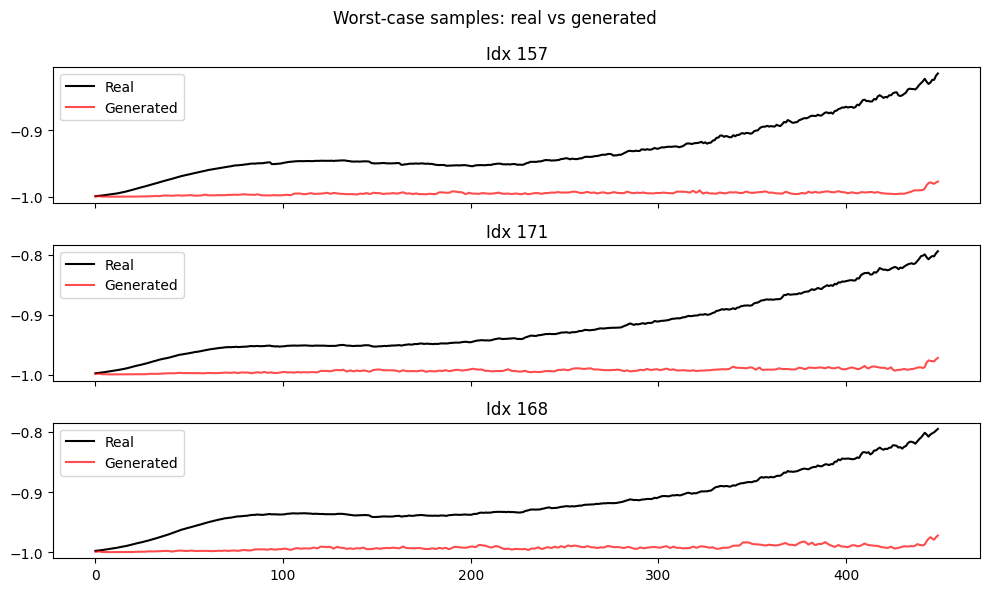

In [18]:
worst_idx = [157, 171, 168]
plot_worst_cases(G, val_dataset, noise_dim, worst_idx, device=device)


In [19]:
bad_indices = [157, 171, 168]

for idx in bad_indices:
    signal, cond = val_dataset[idx]
    print(f"Idx {idx} → cond = {cond.numpy()}")


Idx 157 → cond = [-0.25698319  0.78034514 -1.26777162  0.13429844  1.68872148]
Idx 171 → cond = [-0.25698319  0.78034514 -1.26777162  0.13429844  1.68872148]
Idx 168 → cond = [-0.25698319  0.78034514 -1.26777162  0.13429844  1.68872148]


- E       = -0.257
- perc_N  =  0.780
- P       = -1.268
- gain    =  0.134
- ms      =  1.689


In [22]:
def find_problematic_conditions(df_metrics, dataset, params_csv, corr_threshold=0.6):
    """
    Najde vzorky, kde GAN selhává (nízká korelace),
    a vypíše jejich podmínky.

    Args:
        df_metrics (pd.DataFrame): výstup z validation_metrics_epochXX.csv (sloupce: idx, MSE, Corr)
        dataset (torch Dataset): validační dataset (Signal1DDataset)
        params_csv (str): cesta k params.csv
        corr_threshold (float): práh korelace (např. 0.6)

    Returns:
        pd.DataFrame: tabulka problémových vzorků s jejich podmínkami
    """
    # najdi špatné vzorky
    bad_df = df_metrics[df_metrics["Corr"] < corr_threshold]

    if bad_df.empty:
        print("Žádné problematické vzorky pod prahem.")
        return pd.DataFrame()

    # načti názvy sloupců z params.csv
    params_df = pd.read_csv(params_csv)
    cond_columns = [c for c in params_df.columns if c != "experiment"]

    rows = []
    for _, row in bad_df.iterrows():
        idx = int(row["idx"])
        _, cond = dataset[idx]
        cond_dict = dict(zip(cond_columns, cond.numpy()))
        cond_dict.update({"idx": idx, "MSE": row["MSE"], "Corr": row["Corr"]})
        rows.append(cond_dict)

    result_df = pd.DataFrame(rows)

    # seskupit podle unikátních kombinací podmínek
    grouped = result_df.groupby(cond_columns).size().reset_index(name="count")

    print("\n=== Problematic samples (Corr < {:.2f}) ===".format(corr_threshold))
    print(result_df)

    print("\n=== Unique problematic conditions ===")
    print(grouped)

    return result_df

# načti soubor z nejlepší epochy
df_metrics = pd.read_csv("results02/lambda20_epochs70_20250927_011649/validation_metrics_epoch30.csv")

problems = find_problematic_conditions(
    df_metrics,
    val_dataset,
    "1D_spec/params.csv",
    corr_threshold=0.6
)



=== Problematic samples (Corr < 0.60) ===
          E    perc_N         P      gain        ms  idx       MSE      Corr
0 -0.256983  0.780345 -1.267772  0.134298  1.688721  157  0.004830  0.471849
1 -0.256983  0.780345 -1.267772  0.134298  1.688721  168  0.007148  0.544613
2 -0.256983  0.780345 -1.267772  0.134298  1.688721  169  0.006559  0.568725
3 -0.256983  0.780345 -1.267772  0.134298  1.688721  171  0.007166  0.474699
4 -0.256983  0.780345 -1.267772  0.134298  1.688721  173  0.006348  0.587780
5 -0.256983  0.780345 -1.267772  0.134298  1.688721  174  0.007939  0.583647
6 -0.256983  0.780345 -1.267772  0.134298  1.688721  177  0.006750  0.589462

=== Unique problematic conditions ===
          E    perc_N         P      gain        ms  count
0 -0.256983  0.780345 -1.267772  0.134298  1.688721      7



  ```
  E      = -0.257
  perc_N =  0.780
  P      = -1.268
  gain   =  0.134
  ms     =  1.689
  ```
* Všech 7 těchto signálů má korelaci jen **0.47–0.59**, přestože MSE je pořád malé.

---

## Co to znamená

* GAN si **s tímto konkrétním nastavením podmínek neví rady** → je to „slabé místo“ modelu.
* Buď:

  1. **v tréninkových datech je těchto případů málo** → model se to nenaučil,
  2. **jsou tyto signály hodně variabilní** (víc možných tvarů pro stejné `cond`),
  3. **architektura/loss není dostatečný**, aby to pokryla.


Nalezeno 1 unikátních problematických kombinací podmínek.

=== Vizualizace pro cond {'E': -0.2569831866776762, 'perc_N': 0.7803451383399248, 'P': -1.2677716199312221, 'gain': 0.13429844428189586, 'ms': 1.688721483712806} ===


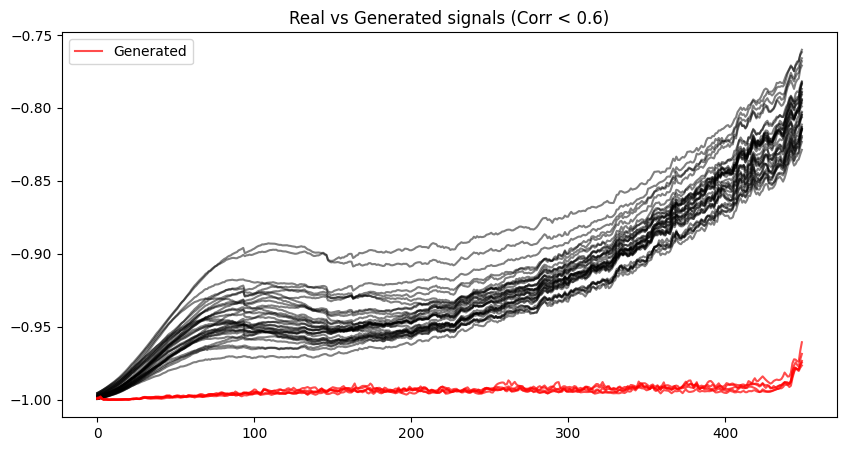

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np

def plot_problematic_conditions(df_metrics, dataset, params_csv, G, noise_dim,
                                device="cpu", corr_threshold=0.6, n_fake=5):
    """
    Najde problematické podmínky (Corr < threshold) a vizualizuje
    reálné i generované signály pro každou kombinaci.

    Args:
        df_metrics (pd.DataFrame): DataFrame z validation_metrics_epochXX.csv
        dataset (Dataset): validační dataset (Signal1DDataset)
        params_csv (str): cesta k params.csv (kvůli názvům sloupců)
        G (nn.Module): trénovaný generátor
        noise_dim (int): rozměr noise vektoru
        device (str): "cpu" nebo "cuda"
        corr_threshold (float): práh pro výběr špatných vzorků
        n_fake (int): kolik fake signálů vygenerovat pro vizualizaci
    """
    params_df = pd.read_csv(params_csv)
    cond_columns = [c for c in params_df.columns if c != "experiment"]

    # vyber problematické vzorky
    bad_df = df_metrics[df_metrics["Corr"] < corr_threshold]
    if bad_df.empty:
        print("Žádné problematické vzorky pod prahem.")
        return

    rows = []
    for _, row in bad_df.iterrows():
        idx = int(row["idx"])
        _, cond = dataset[idx]
        cond_dict = dict(zip(cond_columns, cond.numpy()))
        rows.append(cond_dict)

    # unikatní kombinace
    cond_df = pd.DataFrame(rows).drop_duplicates()

    print(f"Nalezeno {len(cond_df)} unikátních problematických kombinací podmínek.")

    # projdi každou kombinaci
    for cond_idx, cond_values in cond_df.iterrows():
        cond_dict = cond_values.to_dict()
        print(f"\n=== Vizualizace pro cond {cond_dict} ===")

        fig, ax = plt.subplots(figsize=(10, 5))

        # reálné signály
        for i in range(len(dataset)):
            signal, cond = dataset[i]
            cond_dict_i = dict(zip(cond_columns, cond.numpy()))
            if all(abs(cond_dict_i[k] - cond_dict[k]) < 1e-6 for k in cond_columns):
                ax.plot(signal.numpy(), color="black", alpha=0.5, label="Real" if i==0 else "")

        # fake signály
        cond_tensor = torch.tensor([list(cond_dict.values())], dtype=torch.float32).to(device)
        for j in range(n_fake):
            noise = torch.randn(1, noise_dim, device=device)
            with torch.no_grad():
                fake_signal = G(noise, cond_tensor).cpu().numpy().flatten()
            ax.plot(fake_signal, color="red", alpha=0.7, label="Generated" if j==0 else "")

        ax.set_title(f"Real vs Generated signals (Corr < {corr_threshold})")
        ax.legend()
        plt.show()


df_metrics = pd.read_csv(
    "results02/lambda20_epochs70_20250927_011649/validation_metrics_epoch30.csv"
)

plot_problematic_conditions(
    df_metrics,
    val_dataset,
    "1D_spec/params.csv",
    G,
    noise_dim,
    device=device,
    corr_threshold=0.6,
    n_fake=5
)


In [26]:
# načti dataset a jeho statistiky
val_dataset = Signal1DDataset(root_dir="1D_spec", params_csv="1D_spec/params.csv", allowed_experiments=val_exps)

# ulož si mean a std
cond_mean = val_dataset.cond_mean
cond_std  = val_dataset.cond_std

# původní (denormalizované) hodnoty
cond_norm = np.array([-0.256983, 0.780345, -1.267772, 0.134298, 1.688721])  # z problematických vzorků
cond_orig = cond_norm * cond_std + cond_mean

print("Denormalizované hodnoty:", cond_orig)


Loaded 288 files (experiments=[ 8 11 15 20  7])
Global normalization: min=0.0039, max=3.2035
Denormalizované hodnoty: [20.00000084 99.99999986 10.49999707 49.99997932 39.9999948 ]


In [27]:
def denormalize_cond(cond_norm, dataset):
    """
    Převede znormalizované podmínky zpět na původní fyzikální hodnoty.

    Args:
        cond_norm (array-like): znormalizované hodnoty (např. z datasetu/validace)
        dataset (Signal1DDataset): dataset s uloženými cond_mean a cond_std

    Returns:
        np.ndarray: denormalizované (původní) hodnoty
    """
    cond_norm = np.array(cond_norm, dtype=np.float64)
    cond_orig = cond_norm * dataset.cond_std + dataset.cond_mean
    return cond_orig


In [34]:
import numpy as np
import pandas as pd

def denormalize_cond(cond_norm, dataset):
    """
    Denormalize conditions using dataset statistics.
    """
    cond_norm = np.array(cond_norm, dtype=np.float64)
    cond_orig = cond_norm * dataset.cond_std + dataset.cond_mean
    return cond_orig


def find_matching_experiments(cond_norm, dataset, params_csv, tol=1e-5):
    """
    Najde experimenty v params.csv odpovídající denormalizovaným podmínkám.

    Args:
        cond_norm (array-like): normalizované hodnoty (např. z val_dataset)
        dataset (Signal1DDataset): dataset se statistikami (cond_mean, cond_std)
        params_csv (str): cesta k params.csv
        tol (float): tolerance pro porovnání (kvůli zaokrouhlování)

    Returns:
        pd.DataFrame: řádky z params.csv odpovídající daným podmínkám
    """
    # denormalizace
    cond_orig = denormalize_cond(cond_norm, dataset)

    # načti CSV a názvy sloupců
    params_df = pd.read_csv(params_csv)
    cond_columns = [c for c in params_df.columns if c != "experiment"]

    # filtr pomocí tolerance
    mask = np.ones(len(params_df), dtype=bool)
    for col, val in zip(cond_columns, cond_orig):
        mask &= np.isclose(params_df[col], val, atol=tol)

    subset = params_df[mask]

    print("Znormalizované cond:", cond_norm)
    print("Denormalizované cond:", dict(zip(cond_columns, cond_orig)))
    print(f"Nalezeno {len(subset)} odpovídajících experimentů.\n")

    return subset


In [35]:
cond_norm = [-0.256983, 0.780345, -1.267772, 0.134298, 1.688721]

matches = find_matching_experiments(
    cond_norm,
    val_dataset,
    "1D_spec/params.csv",
    tol=1e-5
)

print(matches)


Znormalizované cond: [-0.256983, 0.780345, -1.267772, 0.134298, 1.688721]
Denormalizované cond: {'E': np.float64(20.000000839970436), 'perc_N': np.float64(99.99999985800511), 'P': np.float64(10.499997072002019), 'gain': np.float64(49.999979322603295), 'ms': np.float64(39.99999480138264)}
Nalezeno 3 odpovídajících experimentů.

    experiment   E  perc_N     P  gain  ms
14          15  20     100  10.5    50  40
16          17  20     100  10.5    50  40
17          18  20     100  10.5    50  40


- 3 experimenty s těmito parametry (ID 15, 17, 18).

---

In [1]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt

def plot_real_vs_generated_for_experiments(
    params_csv, root_dir, experiments, dataset,
    G, noise_dim, device="cpu",
    save_dir="results_real_vs_generated", n_fake=3
):
    """
    Vykreslí reálné vs. generované signály pro vybrané experimenty.

    Args:
        params_csv (str): cesta k params.csv
        root_dir (str): složka s daty (podadresáře podle experiment ID)
        experiments (list[int]): seznam experimentů k vykreslení
        dataset (Dataset): Signal1DDataset (kvůli normalizaci podmínek)
        G (nn.Module): natrénovaný generátor
        noise_dim (int): dimenze šumu
        device (str/torch.device): zařízení
        save_dir (str): složka pro uložení obrázků
        n_fake (int): počet generovaných vzorků na každý reálný
    """
    os.makedirs(save_dir, exist_ok=True)
    params_df = pd.read_csv(params_csv)
    G.eval()

    for exp_id in experiments:
        folder_path = os.path.join(root_dir, str(exp_id))
        if not os.path.isdir(folder_path):
            print(f" Složka pro experiment {exp_id} neexistuje.")
            continue

        csv_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".csv")]
        if not csv_files:
            print(f" Žádné CSV soubory pro experiment {exp_id}.")
            continue

        # zjisti podmínky pro tento experiment
        row = params_df[params_df["experiment"] == exp_id].iloc[0].drop("experiment").values.astype(np.float32)
        cond = torch.from_numpy(row).unsqueeze(0).to(device)

        plt.figure(figsize=(10, 6))

        # reálné signály
        for fname in csv_files:
            fpath = os.path.join(folder_path, fname)
            df = pd.read_csv(fpath)
            if "intensity" in df.columns:
                signal = df["intensity"].values
            else:
                signal = df.iloc[:, -1].values
            plt.plot(signal, color="black", alpha=0.6)

        # generované signály
        for _ in range(n_fake):
            noise = torch.randn(1, noise_dim, device=device)
            with torch.no_grad():
                fake_signal = G(noise, cond).cpu().numpy().flatten()
            plt.plot(fake_signal, color="red", alpha=0.7)

        # titulek
        cond_dict = params_df[params_df["experiment"] == exp_id].iloc[0].to_dict()
        cond_str = ", ".join([f"{k}={v}" for k, v in cond_dict.items() if k != "experiment"])
        plt.title(f"Experiment {exp_id} | {cond_str}")
        plt.xlabel("Index")
        plt.ylabel("Intensity")
        plt.tight_layout()

        out_path = os.path.join(save_dir, f"exp{exp_id}_real_vs_generated.png")
        plt.savefig(out_path, dpi=200)
        plt.close()

        print(f" Uloženo: {out_path}")


In [11]:
import os
import json
import torch
import pandas as pd

# === 1. Cesty ===
root_dir = "1D_spec"
params_csv = os.path.join(root_dir, "params.csv")
split_file = os.path.join("results", "dataset_split.csv")

# složka nejlepšího běhu (dosaď podle sebe!)
best_run_dir = "results02/lambda20_epochs70_20250927_011649"

# === 2. Načti split a vytvoř val_dataset ===
split_df = pd.read_csv(split_file)
val_exps = split_df.query("set == 'val'")["experiment"].tolist()
val_dataset = Signal1DDataset(root_dir, params_csv, allowed_experiments=val_exps)

# === 3. Načti config ===
with open(os.path.join(best_run_dir, "config.json")) as f:
    config = json.load(f)

noise_dim = config["noise_dim"]
cond_dim = config["cond_dim"]
signal_len = config["signal_len"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Použité zařízení:", device)

# === 4. Postav a nahraj modely ===
G = Generator1D(noise_dim=noise_dim, cond_dim=cond_dim, signal_len=signal_len).to(device)
G.load_state_dict(torch.load(os.path.join(best_run_dir, "generator.pth"), map_location=device))
G.eval()

D = Discriminator1D(cond_dim=cond_dim, signal_len=signal_len).to(device)
D.load_state_dict(torch.load(os.path.join(best_run_dir, "discriminator.pth"), map_location=device))
D.eval()

print("Nejlepší model nahrán.")

# === 5. Vykresli real vs. generated signály pro experimenty 15, 17, 18 ===
plot_real_vs_generated_for_experiments(
    params_csv=params_csv,
    root_dir=root_dir,
    experiments=[15, 17, 18],
    dataset=val_dataset,
    G=G,
    noise_dim=noise_dim,
    device=device,
    save_dir="results_real_vs_generated",
    n_fake=5
)


Loaded 288 files (experiments=[8, 11, 15, 20, 7])
Global normalization: min=0.0039, max=3.2035
Použité zařízení: cpu
Nejlepší model nahrán.
 Uloženo: results_real_vs_generated/exp15_real_vs_generated.png
 Uloženo: results_real_vs_generated/exp17_real_vs_generated.png
 Uloženo: results_real_vs_generated/exp18_real_vs_generated.png


In [12]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

def plot_real_vs_generated_for_experiments(
    params_csv, root_dir, experiments, dataset,
    G, noise_dim, device="cpu",
    save_dir="results_real_vs_generated", n_fake=3
):
    """
    Vykreslí reálné vs. generované signály pro vybrané experimenty
    a uloží metriky (MSE, Corr) do CSV.

    Args:
        params_csv (str): cesta k params.csv
        root_dir (str): složka s daty (podadresáře podle experiment ID)
        experiments (list[int]): seznam experimentů k vykreslení
        dataset (Dataset): Signal1DDataset (kvůli normalizaci podmínek)
        G (nn.Module): natrénovaný generátor
        noise_dim (int): dimenze šumu
        device (str/torch.device): zařízení
        save_dir (str): složka pro uložení výsledků
        n_fake (int): počet generovaných vzorků na každý experiment
    """
    os.makedirs(save_dir, exist_ok=True)
    params_df = pd.read_csv(params_csv)
    G.eval()

    all_results = []

    for exp_id in experiments:
        folder_path = os.path.join(root_dir, str(exp_id))
        if not os.path.isdir(folder_path):
            print(f"Složka pro experiment {exp_id} neexistuje.")
            continue

        csv_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".csv")]
        if not csv_files:
            print(f"Žádné CSV soubory pro experiment {exp_id}.")
            continue

        # zjisti podmínky pro tento experiment
        row = params_df[params_df["experiment"] == exp_id].iloc[0].drop("experiment").values.astype(np.float32)
        cond = torch.from_numpy(row).unsqueeze(0).to(device)

        plt.figure(figsize=(10, 6))

        real_signals = []
        # reálné signály
        for fname in csv_files:
            fpath = os.path.join(folder_path, fname)
            df = pd.read_csv(fpath)
            if "intensity" in df.columns:
                signal = df["intensity"].values
            else:
                signal = df.iloc[:, -1].values
            real_signals.append(signal)
            plt.plot(signal, color="black", alpha=0.6)

        # generované signály
        for fake_idx in range(n_fake):
            noise = torch.randn(1, noise_dim, device=device)
            with torch.no_grad():
                fake_signal = G(noise, cond).cpu().numpy().flatten()
            plt.plot(fake_signal, color="red", alpha=0.7)

            # spočítej metriky vůči všem reálným signálům
            for real_idx, real_signal in enumerate(real_signals):
                mse = mean_squared_error(real_signal, fake_signal)
                corr, _ = pearsonr(real_signal, fake_signal)
                all_results.append({
                    "experiment": exp_id,
                    "real_file": csv_files[real_idx],
                    "fake_id": fake_idx,
                    "MSE": mse,
                    "Corr": corr
                })

        # titulek
        cond_dict = params_df[params_df["experiment"] == exp_id].iloc[0].to_dict()
        cond_str = ", ".join([f"{k}={v}" for k, v in cond_dict.items() if k != "experiment"])
        plt.title(f"Experiment {exp_id} | {cond_str}")
        plt.xlabel("Index")
        plt.ylabel("Intensity")
        plt.tight_layout()

        out_path = os.path.join(save_dir, f"exp{exp_id}_real_vs_generated.png")
        plt.savefig(out_path, dpi=200)
        plt.close()

        print(f"Uloženo: {out_path}")

    # uložit metriky
    df_results = pd.DataFrame(all_results)
    csv_out = os.path.join(save_dir, "metrics_real_vs_generated.csv")
    df_results.to_csv(csv_out, index=False)
    print(f"Metriky uloženy do {csv_out}")

    return df_results


In [13]:
df_results = plot_real_vs_generated_for_experiments(
    params_csv=params_csv,
    root_dir=root_dir,
    experiments=[15, 17, 18],
    dataset=val_dataset,
    G=G,
    noise_dim=noise_dim,
    device=device,
    save_dir="results_real_vs_generated",
    n_fake=5
)

print(df_results.head())


Uloženo: results_real_vs_generated/exp15_real_vs_generated.png
Uloženo: results_real_vs_generated/exp17_real_vs_generated.png
Uloženo: results_real_vs_generated/exp18_real_vs_generated.png
Metriky uloženy do results_real_vs_generated/metrics_real_vs_generated.csv
   experiment real_file  fake_id       MSE      Corr
0          15     6.csv        0  1.255246  0.110972
1          15     7.csv        0  1.318959  0.102167
2          15     5.csv        0  1.254780  0.094869
3          15     4.csv        0  1.233184  0.112172
4          15     0.csv        0  1.323328  0.116492


In [14]:
import torch
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim

# === FFT loss ===
def fft_loss(real, fake):
    real_fft = torch.fft.rfft(real, dim=1)
    fake_fft = torch.fft.rfft(fake, dim=1)
    return torch.mean(torch.abs(torch.abs(real_fft) - torch.abs(fake_fft)))


# === Gradient penalty ===
def gradient_penalty(D, real_data, fake_data, cond, device="cpu", lambda_gp=10):
    b_size = real_data.size(0)
    alpha = torch.rand(b_size, 1, device=device)
    alpha = alpha.expand_as(real_data)

    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    d_interpolates = D(interpolates, cond)

    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(b_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    gp = ((gradient_norm - 1) ** 2).mean() * lambda_gp
    return gp


# === Hlavní trénovací smyčka ===
def train_wgan_gp_l1_advanced(
    G, D, train_loader, noise_dim, num_epochs=50,
    lr_G=1e-4, lr_D=5e-5, device="cpu",
    n_critic=2, lambda_gp=1.0,
    lambda_l1=10.0, lambda_fft=2.0,
    l1_decay_every=None,
    problematic_exps=None
):
    """
    Trénování WGAN-GP s váženým L1 a FFT losem.
    """
    optimizer_G = optim.Adam(G.parameters(), lr=lr_G, betas=(0.0, 0.9))
    optimizer_D = optim.Adam(D.parameters(), lr=lr_D, betas=(0.0, 0.9))

    history = {"loss_D": [], "loss_G": [], "lambda_l1": [], "lambda_fft": []}

    for epoch in range(num_epochs):
        loss_D_epoch, loss_G_epoch = 0.0, 0.0

        # decay λL1
        if l1_decay_every is not None and (epoch > 0) and (epoch % l1_decay_every == 0):
            lambda_l1 = lambda_l1 / 2.0
            print(f"[Epoch {epoch}] Snižuji lambda_l1 → {lambda_l1}")

        for signals, conds, exp_ids in train_loader:
            signals = signals.to(device).float()
            conds = conds.to(device).float()
            exp_ids = exp_ids.to(device)
            b_size = signals.size(0)

            # === Discriminator ===
            for _ in range(n_critic):
                noise = torch.randn(b_size, noise_dim, device=device)
                fake_signals = G(noise, conds)

                D.zero_grad()
                real_validity = D(signals, conds)
                fake_validity = D(fake_signals.detach(), conds)

                gp = gradient_penalty(D, signals, fake_signals, conds, device, lambda_gp)
                loss_D = fake_validity.mean() - real_validity.mean() + gp

                loss_D.backward()
                optimizer_D.step()

            # === Generator ===
            noise = torch.randn(b_size, noise_dim, device=device)
            fake_signals = G(noise, conds)

            G.zero_grad()
            fake_validity = D(fake_signals, conds)

            adv_loss = -fake_validity.mean()

            # vážený L1
            weights = torch.ones(b_size, device=device)
            if problematic_exps is not None:
                for i, exp_id in enumerate(exp_ids):
                    if int(exp_id.item()) in problematic_exps:
                        weights[i] = 2.0  # zdvojnásobíme váhu
            l1_loss = F.l1_loss(fake_signals, signals, reduction="none").mean(dim=1)
            l1_loss = (l1_loss * weights).mean()

            # FFT loss
            fft_l = fft_loss(signals, fake_signals)

            # celkový loss
            loss_G = adv_loss + lambda_l1 * l1_loss + lambda_fft * fft_l

            loss_G.backward()
            optimizer_G.step()

            loss_D_epoch += loss_D.item()
            loss_G_epoch += loss_G.item()

        # průměry za epochu
        loss_D_epoch /= len(train_loader)
        loss_G_epoch /= len(train_loader)
        history["loss_D"].append(loss_D_epoch)
        history["loss_G"].append(loss_G_epoch)
        history["lambda_l1"].append(lambda_l1)
        history["lambda_fft"].append(lambda_fft)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Loss_D: {loss_D_epoch:.4f} Loss_G: {loss_G_epoch:.4f} "
              f"(λL1={lambda_l1:.2f}, λFFT={lambda_fft:.2f})")

    return history


In [16]:
from torch.utils.data import DataLoader

root_dir = "1D_spec"
params_csv = os.path.join(root_dir, "params.csv")
split_file = os.path.join("results", "dataset_split.csv")

# načti split
split_df = pd.read_csv(split_file)
train_exps = split_df.query("set == 'train'")["experiment"].tolist()
val_exps   = split_df.query("set == 'val'")["experiment"].tolist()

# dataset + dataloader
train_dataset = Signal1DDataset(root_dir, params_csv, allowed_experiments=train_exps)
val_dataset   = Signal1DDataset(root_dir, params_csv, allowed_experiments=val_exps)
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True)

problematic_exps = {15, 17, 18}

G = Generator1D(noise_dim=noise_dim, cond_dim=cond_dim, signal_len=signal_len).to(device)
D = Discriminator1D(cond_dim=cond_dim, signal_len=signal_len).to(device)

history = train_wgan_gp_l1_advanced(
    G, D, train_loader, noise_dim,
    num_epochs=70,
    device=device,
    lr_G=1e-4, lr_D=5e-5,
    n_critic=2,
    lambda_gp=1.0, lambda_l1=10.0, lambda_fft=2.0,
    problematic_exps=problematic_exps
)


Loaded 991 files (experiments=[1, 14, 9, 2, 16, 6, 21, 12, 4, 5, 18, 13, 19, 17, 3, 10, 22])
Global normalization: min=0.0015, max=6.9025
Loaded 288 files (experiments=[8, 11, 15, 20, 7])
Global normalization: min=0.0039, max=3.2035


ValueError: not enough values to unpack (expected 3, got 2)